> # Анализ базы данных c индексом цен корма для собак “PriceIndexDogFood”



### Данные
Для итоговой аттестации использован dataset “PriceIndexDogFood.csv” из архива по ссылке: https://drive.google.com/file/d/1NAeoMzgTTwfBLok-nUdY3Ef3w4Fa7YG4/view 

### Введение
Данный датасет необходим для интерпретирования данных, например, для понимания сезонного изменения цен за 1 кг корма для собак, и предсказания будущих значений временного ряда по настоящим и прошлым значениям.


---



Цель:проведение исследования данных и построение прогноза изменения цен на корм для собак.

 Задачи:
* провести анализ данных об изменении цены на корм;
* выбрать модели для прогнозирования;
* составить прогноз изменения индекса цен на корм для собак на год вперед;
* оценить эффективность прогнозируемых моделей.

#### Импорт библиотек, ознакомление с данными

In [ ]:
# загружаем pmdarima
!pip install pmdarima

In [ ]:
# загружаем fbprophet
!pip install fbprophet

In [4]:
import pandas as pd
import numpy as np
%matplotlib inline

# импорт SARIMAX 
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # для определения (p,q) 
from statsmodels.tsa.seasonal import seasonal_decompose      # для ETS графиков
from pmdarima import auto_arima                              # для поиска ARIMA моделей
from fbprophet import Prophet                               # для модели Prophet

# метрики
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import rmse

# Загрузка данных
df = pd.read_csv('/content/sample_data/PriceIndexDogFood.csv',index_col='Date',parse_dates=True)
df.index.freq = 'MS'                                        #создаем индекс с частотой начала месяца
print(len(df))                                              # выводим количество записей в df
print(df.head())

397
            DogFood
Date               
1985-12-01    100.0
1986-01-01    100.2
1986-02-01    100.3
1986-03-01    100.2
1986-04-01    100.7


#### Проверяем, что все выгрузилось корректно

In [5]:
df.head(398)

,DogFood
Date,
1985-12-01,100.0
1986-01-01,100.2
1986-02-01,100.3
1986-03-01,100.2
1986-04-01,100.7
...,...
2018-08-01,236.3
2018-09-01,236.3
2018-10-01,236.3


In [6]:
# смотрим общую информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-12-01 to 2018-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DogFood  397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


---
Мы видим, что датасет соержит 397 записей и 1 колонку. Данные представляют собой индекс цен корма для собак в среднем за месяц, начиная с декабря 1985 года по декабрь 2018 года.

---



#### Динамика изменения индекса цен

[Text(0, 0.5, 'Стоимость 1 кг корма'), Text(0.5, 0, '')]

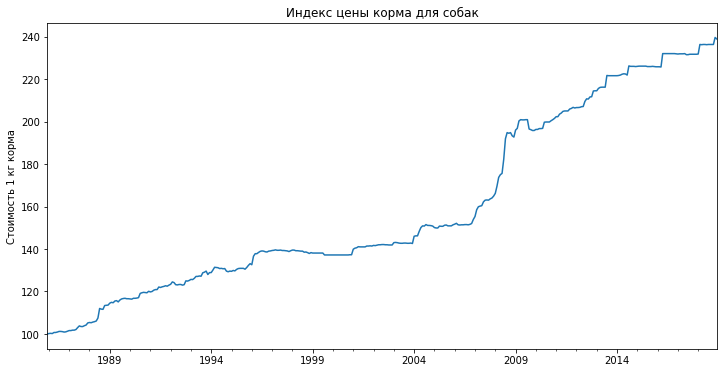

In [7]:
# Добавим название графика и название оси Y
title = 'Индекс цены корма для собак'
ylabel = 'Стоимость 1 кг корма'
xlabel = '' #по сравнению с ожидаемым результатом не указываем название оси Х

ax = df['DogFood'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

---
На графике виден отчетливый тренд - средний индекс цен постепенно растет, но в 2009 год происходит резкий "скачок" и, начиная с 2010 года индекс цен постепенно повышается.

---






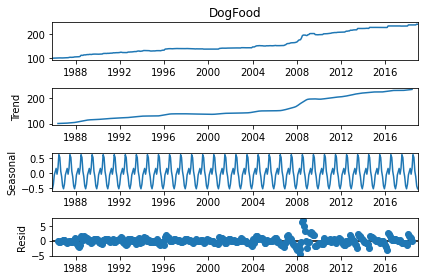

In [61]:
# отобразите результат
r = seasonal_decompose(df['DogFood'], model='additive')

r.plot();

# обнаруживаем годовую сезонность

Полученные графики демонстрируют наличие сезонности, что подтверждает верность выбора модели прогнозирования SARIMA. Также видно, что тренд присутствует.

---



## Построение моделей

### Рассмотрим прогноз SARIMA
Запустим метод pmdarima.auto_arima чтобы получить набор параметров. Включим сезонность и укажем период сезонности равный 1 году.

In [8]:
auto_arima(df['DogFood'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  397
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -579.912
Date:                            Fri, 25 Mar 2022   AIC                           1167.824
Time:                                    06:36:25   BIC                           1183.750
Sample:                                         0   HQIC                          1174.134
                                            - 397                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2380      0.078      3.059      0.002       0.086       0.391
ar.L1          0.2423      0.024     10.126      0.000       0.195       0.289
ar.S.L12       0.1018      0.049      2.075      0.038       0.006       0.198
sigma2         1.0947      0.041     26.808      0.000       1.015       1.175
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              5249.17
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               4.35   Skew:                             3.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

---
Используем для дальнейшего анализа: SARIMAX(1, 1, 0)x(1, 0, 0, 12).

Трендовый и сезонный гиперпараметры указываются как кортежи из 3 и 4 элементов соответственно.

SARIMAX (p, d , q)x(P, D, Q, m):
* p - порядок авторегрессии тренда
* d - порядок изменения тренда
* q - тренд скользящей средней
* P - сезонный порядок авторегрессии
* D - порядок сезонных разниц
* Q - сезонный порядок скользящих средних
* m - количество временных шагов за один сезонный пеиод
---



Мы можем обучить нашу модель на данных до января 2018 (обучающая выборка), а на данных 2018 года (контрольная выборка) проверить, хорошо ли наша модель предсказывает. Разделим данные на обучающую и контрольную группы. Установим один год (12 записей) для тестирования

In [9]:
train = df.iloc[:len(df)-12]   #обучающая выборка
test = df.iloc[len(df)-12:]    #контрольная выборка

Обучим модель на подобранных параметрах SARIMAX(1, 1, 0)x(1, 0, 0, 12).

In [10]:
model = SARIMAX(train['DogFood'],order=(1, 1, 0),seasonal_order=(1, 0, 0, 12)) #модель
#обучаем модель на обучающей выборке данных
results = model.fit()
#получаем результаты
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            DogFood   No. Observations:                  385
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -561.048
Date:                            Fri, 25 Mar 2022   AIC                           1128.097
Time:                                    06:36:42   BIC                           1139.949
Sample:                                12-01-1985   HQIC                          1132.798
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3209      0.023     13.699      0.000       0.275       0.367
ar.S.L12       0.1417      0.046      3.094      0.002       0.052       0.231
sigma2         1.0869      0.031     35.514      0.000       1.027       1.147
===================================================================================
Ljung-Box (L1) (Q):                   1.41   Jarque-Bera (JB):              4880.65
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               3.75   Skew:                             3.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Получаем прогнозируемые значения и пытаемся оценить качество прогноза:

In [11]:
start=len(train) #первая точка в тестовом множестве
end=len(train)+len(test)-1 #последняя точка в тестовом множеств

#предсказываем значения,передав модели results точку начала и окончания на указанном периоде
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('Прогноз SARIMAX(1, 1, 0)x(1, 0, 0, 12)')

Выведем на график прогнозируемые и тестовые значения

[Text(0, 0.5, 'Стоимость 1 кг корма'), Text(0.5, 0, '')]

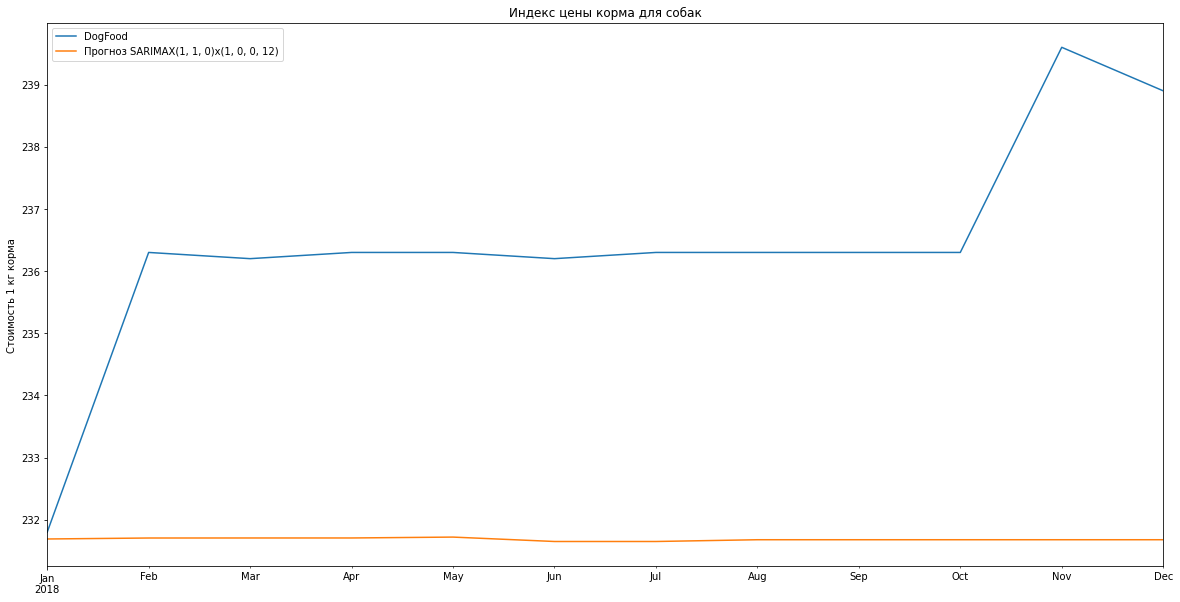

In [14]:
#Сравниваем прогнозируемые и тестовые значения
title = 'Индекс цены корма для собак'
ylabel = 'Стоимость 1 кг корма'
xlabel = '' 

ax = test['DogFood'].plot(legend=True,  figsize=(20,10),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

На данном промежутке времени мы видим небольшую регрессию по сезону и по тренду (пример случайного тренда)

In [13]:
# Оценим качество полученного прогноза на тестовой выборке с помощью метрик MSE, RMSE и MAPE
mse_value = mean_squared_error(test['DogFood'], predictions) #Cреднеквадратичная ошибка
rmse_value = rmse(test['DogFood'], predictions) #Квадратный корень из среднеквадратичной ошибки
mape_error = np.mean(np.abs(predictions - test['DogFood'])/test['DogFood'])*100 #Cредняя абсолютная ошибка в процентах

print(f'SARIMA(1, 1, 0)x(1, 0, 0, 12) MSE Error: {mse_value:11.10}')
print(f'SARIMA(1, 1, 0)x(1, 0, 0, 12) RMSE Error: {rmse_value:11.10}')
print(f'SARIMA(1, 1, 0)x(1, 0, 0, 12) MAPE Error: {mape_error:11.10}')

SARIMA(1, 1, 0)x(1, 0, 0, 12) MSE Error: 25.39034039
SARIMA(1, 1, 0)x(1, 0, 0, 12) RMSE Error: 5.038882851
SARIMA(1, 1, 0)x(1, 0, 0, 12) MAPE Error: 1.988859125


Качество получаемого прогноза в тестовой выборке по средней абсолютной ошибке составляет приблизительно 1,99 %

### Т.о. натренеруем модель на полном датасете и составим прогноз на год вперед

In [ ]:
model = SARIMAX(df['DogFood'], order=(1, 1, 0),seasonal_order=(1, 0, 0, 12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            DogFood   No. Observations:                  397
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -588.813
Date:                            Thu, 24 Mar 2022   AIC                           1183.625
Time:                                    23:34:59   BIC                           1195.570
Sample:                                12-01-1985   HQIC                          1188.357
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2954      0.024     12.136      0.000       0.248       0.343
ar.S.L12       0.1472      0.048      3.079      0.002       0.054       0.241
sigma2         1.1446      0.033     34.827      0.000       1.080       1.209
===================================================================================
Ljung-Box (L1) (Q):                   1.60   Jarque-Bera (JB):              4445.74
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               4.19   Skew:                             2.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Задаем точки следующего года:

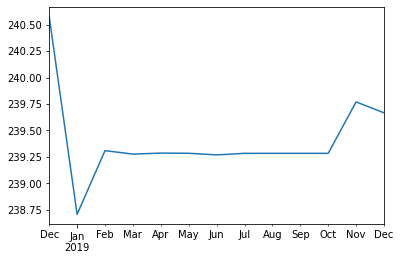

In [ ]:
fcast = results.predict(len(df)-1,len(df)+11,typ='levels').rename('SARIMAX(1, 1, 0)x(1, 0, 0, 12) Прогноз')

#построим график предсказаний
fcast.plot()

[Text(0, 0.5, 'Стоимость 1 кг корма'), Text(0.5, 0, '')]

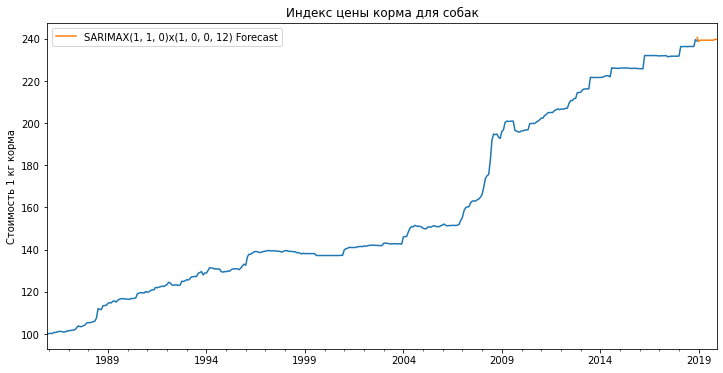

In [ ]:
# Построим общий график с исходными и прогнозными значениями на 1 год
title = 'Индекс цены корма для собак'
ylabel = 'Стоимость 1 кг корма'
xlabel = '' #по сравнению с ожидаемым результатом не указываем название оси Х

ax = df['DogFood'].plot(figsize=(12,6),title=title)
fcast.plot(legend = True)
ax.autoscale(axis= 'x', tight = True)
ax.set(xlabel = xlabel, ylabel = ylabel)

## Выводы по модели SARIMA:
Полученные результаты являются удовлетворительными:

По результатам видно примерное соответствие графиков прогнозной и тестовой выборок.
Cредняя абсолютная ошибка в процентах приблизительно равна 1,99%, что также достаточно неплохо.
Модель предсказывает сохранение сезонности и стабильной регрессии в последующие 12 месяцев. Т.о. модель может быть использована в работе для дальнейшего прогнозирования.

## Построим модель и прогноз, используя билиотеку Prophet

In [45]:
#Создадим model_2, присвоив ей объект Prophet()
model = Prophet()
model

Устанавливаем нужные нам поля. Датасеты обучающей и тестовой выборок проиндексированы по дате, поэтому для прямого обращения к атрибуту date сбросим индексы

In [46]:
train_0 = train.reset_index() #Индекс сбросим, чтобы работать только с колонками.
test_0 = test.reset_index() #Индекс сбросим, чтобы работать только с колонками.

In [49]:
# Переименуем столбцы в обучающем и тестовом датасетах, чтобы они подходили для использования методов Prophet
# ds — временная гранула, в нашем случае месяцы
# y — значения, которые будем предсказывать, в нашем случае индекс цены
train_0.columns = ['ds', 'y']
test_0.columns = ['ds', 'y']

In [50]:
train_0.head() #посмотрим преобразование после переименования колонок

,ds,y
0,1985-12-01,100.0
1,1986-01-01,100.2
2,1986-02-01,100.3
3,1986-03-01,100.2
4,1986-04-01,100.7


In [51]:
model.fit(train_0) # подогнали модель под наши данные

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Алгоритмом обнаружена годовая сезонность, которая используется при настройке модели. Не учитывается недельная и дневная сезонность. Для учета недельной сезонности для модели необходимо иметь данные минимум за месяц, а для дневной - данные по часам/минутам.

---



### Качество модели
Посмотрим на качество получившейся модели. Для этого нам необходимо задать горизонт прогнозирования (в нашем случае это год) и создать дата-фрейм с датами из «будущего», для которого модель потом будет строить прогноз.
Так как наши данные имеют месячную гранулярность, прогноз мы также получим по месяцам от последней даты на количество месяцев, указанное в скобках.

In [52]:
future = model.make_future_dataframe(periods=12, freq='MS') # говорим профету сделать дата-фрейм на 12 месяцев
future.tail(12) # выводим 12 последних месяцев

,ds
385,2018-01-01
386,2018-02-01
387,2018-03-01
388,2018-04-01
389,2018-05-01
390,2018-06-01
391,2018-07-01
392,2018-08-01
393,2018-09-01
394,2018-10-01


In [53]:
#строим прогноз, записываем в отдкльную переменную
forecast = model.predict(future)
forecast.head() # возвращает много колонок

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1985-12-01,97.464095,94.067912,100.433499,97.464095,97.464095,-0.304331,-0.304331,-0.304331,-0.304331,-0.304331,-0.304331,0.0,0.0,0.0,97.159764
1,1986-01-01,97.858431,94.971407,101.050595,97.858431,97.858431,0.179050,0.179050,0.179050,0.179050,0.179050,0.179050,0.0,0.0,0.0,98.037480
2,1986-02-01,98.252767,95.443349,101.620205,98.252767,98.252767,0.305443,0.305443,0.305443,0.305443,0.305443,0.305443,0.0,0.0,0.0,98.558210
3,1986-03-01,98.608941,96.082637,102.031889,98.608941,98.608941,0.499296,0.499296,0.499296,0.499296,0.499296,0.499296,0.0,0.0,0.0,99.108238
4,1986-04-01,99.003277,96.184369,102.566307,99.003277,99.003277,0.404821,0.404821,0.404821,0.404821,0.404821,0.404821,0.0,0.0,0.0,99.408098


Основные поля в прогнозе следующие:

* ds — дата прогноза

* yhat — спрогнозированное значение

* yhat_lower — нижняя граница доверительного интервала для прогноза

* yhat_upper — верхняя граница доверительного интервала для прогноза

In [54]:
# выводим основные поля последних значений
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
392,2018-08-01,240.437797,237.275070,243.752229
393,2018-09-01,240.515278,237.484825,243.670478
394,2018-10-01,240.731326,237.458282,243.985756
395,2018-11-01,240.795048,237.524579,244.165478
396,2018-12-01,241.121526,237.772038,244.437372


При помощи метода plot сравниваем график по прогнозу и обучающей выборке (черные точки)

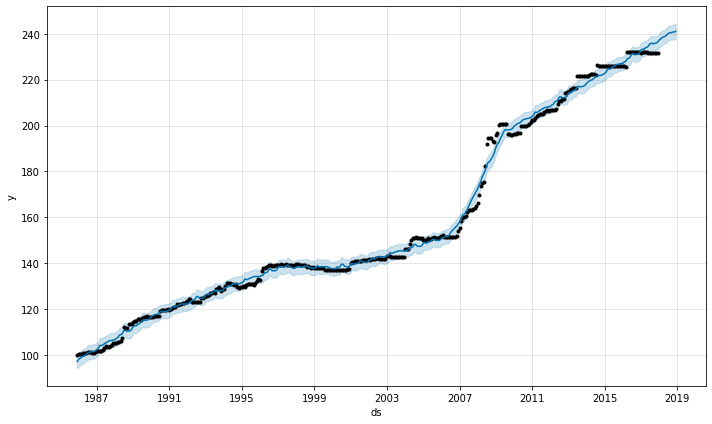

In [55]:
model.plot(forecast);

Разложим ряд на основные компоненты — тренд и сезонность:

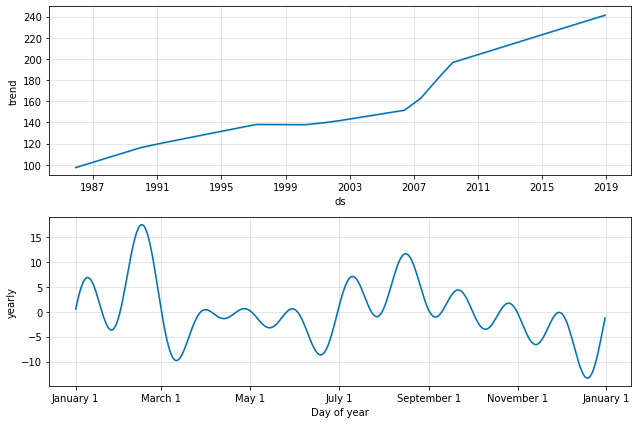

In [56]:
model.plot_components(forecast);

Видим, что тренд у индекса цен возрастающий и у нас есть четкая годовая сезонность:

* индекс цены высокий в феврале-марте;
* индекс цен падает в конце декабря-начале февраля.


---



### Оценим качество полученного прогноза на тестовой выборке с помощью метрик MSE, RMSE и MAPE

In [59]:
# Оценим качество полученного прогноза на тестовой выборке с помощью метрик MSE, RMSE и MAPE
mse_value = mean_squared_error(test_0 ['y'], forecast['yhat'].tail(12))      #Cреднеквадратичной ошибкf
rmse_value = rmse(test_0 ['y'], forecast['yhat'].tail(12))                   #Квадратный корень из среднеквадратичной ошибки
mape_value = np.mean(np.abs(forecast['yhat'] - test_0['y'])/test_0['y'])*100  #Cредняя абсолютная ошибка в процентах
print(f'Prophet MSE Error: {mse_value:11.10}')
print(f'Prophet RMSE Error: {rmse_value:11.10}')
print(f'Prophet MAPE Error: {mape_error:11.10}')

Prophet MSE Error:  11.1938026
Prophet RMSE Error: 3.345714065
Prophet MAPE Error: 1.988859125


Полученные результаты в целом удовлитворительные:

Cредняя абсолютная ошибка в процентах = 1.988859125% соответствует с моделью по SARIMA (SARIMA MAPE Error = 1.988859125%).

При этом среднеквадратичная ошибка меньше:

*   Prophet MSE Error:  11.1938026
*   SARIMA MSE Error = 25.39034039

И соответственно квадратный корень из среднеквадратичной ошибки:
*   Prophet RMSE Error: 3.345714065
*   SARIMARMSE Error= 5.038882851

---



## Заключение

Для решения поставленных задач были выполнены следующие шаги:
* проведен анализ статистических данных об изменении индекса цен на корм для собак;
* определены модели для прогнозирования и основные метрики, построены графики временных рядов для данных метрик;
* составлен прогноз индекса цен на корм для собак на год вперед, используя две основные модели прогноза SARIMA и Prophet;
* дана оценка моделей эффективности моделей.

По результатам статистического анализа можно сделать следующие заключения:

*   результаты прогнозов удовлетворительные с сохранением тенденций на индекс цен и сезонность;
*   среди изученных моделей обе модели прогнозирования показали хорошие результаты, средняя абсолютная ошибка была одинаковой, всего 1,99%.